In [5]:
import networkx as nx
from SPARQLWrapper import SPARQLWrapper, JSON
import yaml
import collections
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib.colors as colors

In [6]:
plt.rcParams['figure.figsize'] = 20, 15
plt.rcParams['font.size'] = 16
plt.rcParams['font.family'] = 'Lato'
plt.rcParams['figure.facecolor'] = 'white'

sparql_base = 'sparql/'

In [7]:
with open('config.yaml') as file:
    config = yaml.load(file, Loader=yaml.SafeLoader)

In [8]:
query_string = open(sparql_base + 'pages.rq', 'r').read()
sparql = SPARQLWrapper(config['sparql_enpoint'])
sparql.setQuery(query_string)
sparql.setReturnFormat(JSON)

res = sparql.query().convert()

Construct the graph

In [50]:
g = nx.DiGraph()
for r in res['results']['bindings']:
    p_type = r['pageType1']['value']
    g.add_node(
        r['label1']['value'],
        exists=(r['exists1']['value'] == 'true'),
        is_restart=(
                p_type == 'Typ strony Gry:Restart' or
                p_type == 'Typ strony Gry:Śmierć' or
                p_type == 'Typ strony Gry:Początek trybu'
        )
    )
    for target in r['links']['value'].split('|'):
        if target == '':
            continue
        g.add_edge(r['label1']['value'], target)

# restrict the graph to pages that exist
g = g.subgraph([v for v, exists in g.nodes(data='exists') if exists]).copy()

Degree distribution

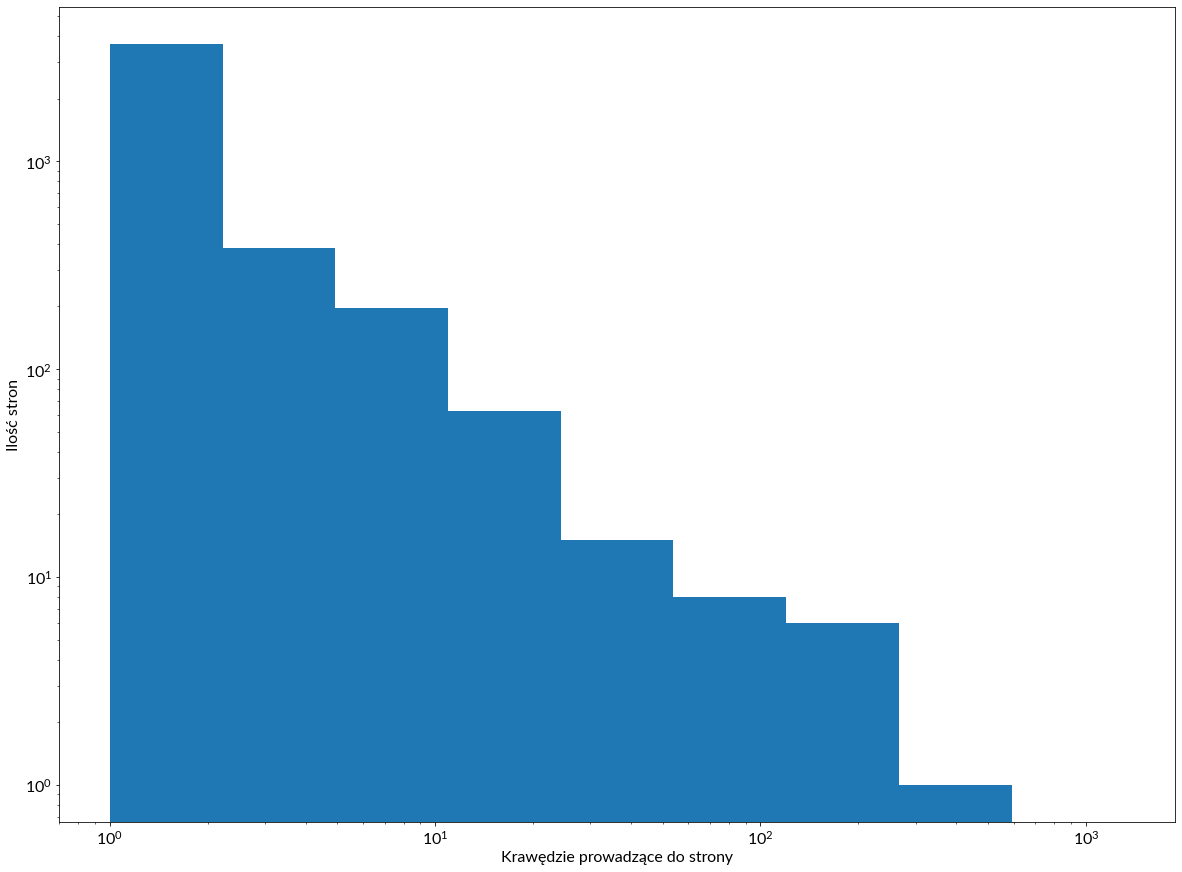

In [52]:
dist_bins = None

def plot_degree_dist(g_dist):
    global dist_bins

    degrees = np.array([v for k, v in g_dist.in_degree if v > 0])
    if dist_bins is None:
        dist_bins = np.logspace(np.log10(np.min(degrees)), np.log10(np.max(degrees)), 10)

    plt.hist(degrees, bins=dist_bins)
    plt.yscale('log')
    plt.ylabel('Ilość stron')
    plt.xscale('log')
    plt.xlabel('Krawędzie prowadzące do strony')

plot_degree_dist(g)
plt.savefig('img/degree_dist1.svg')

Remove links to restarts

In [53]:
e_to_remove = []
for v, is_restart in g.nodes(data='is_restart'):
    if is_restart:
        e_to_remove.extend(g.in_edges(v))

g.remove_edges_from(e_to_remove)

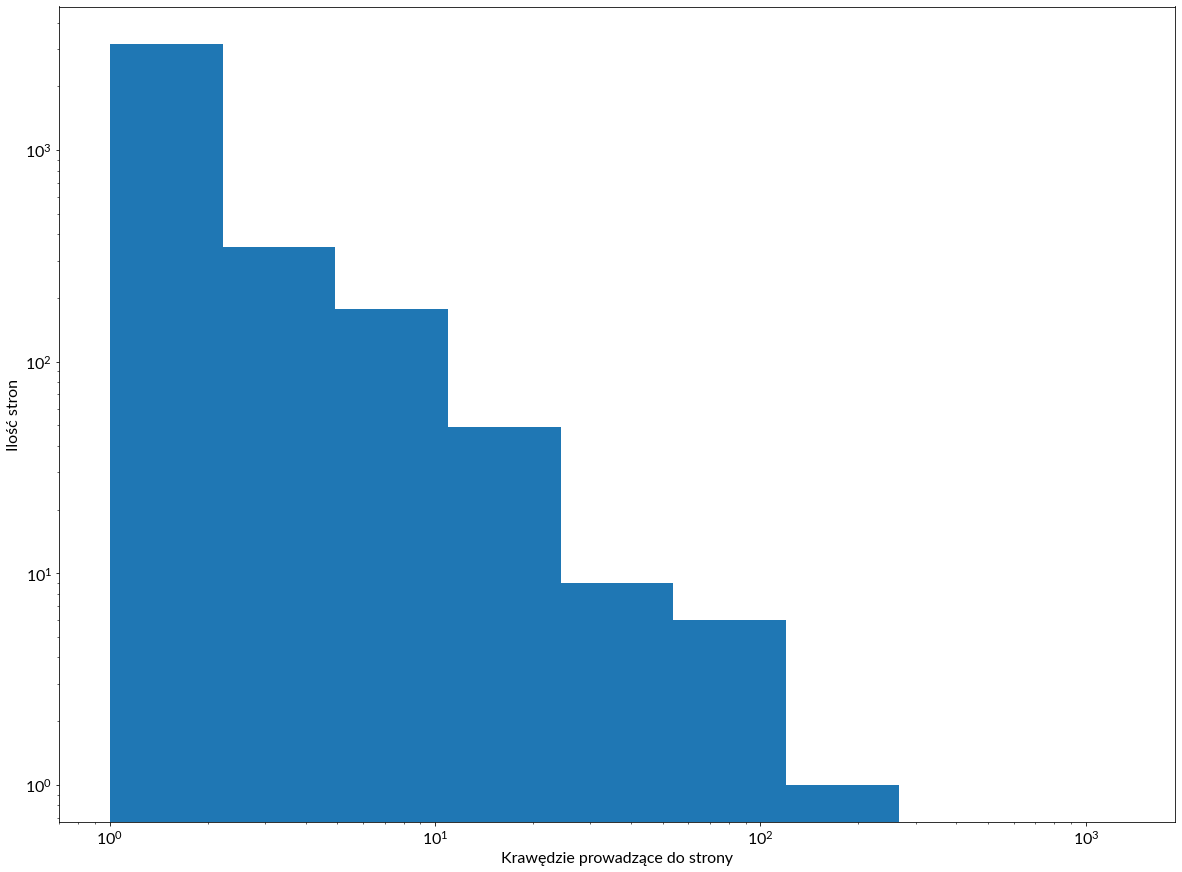

In [54]:
plot_degree_dist(g)
plt.savefig('img/degree_dist2.svg')

Weak connectivity

In [11]:
collections.Counter([len(x) for x in nx.weakly_connected_components(g)])

Counter({3903: 1, 1: 481, 2: 3, 3: 1})

Strong connectivity

In [12]:
collections.Counter([len(x) for x in nx.strongly_connected_components(g)])



Counter({1: 1448, 2: 18, 4: 2, 5: 4, 6: 1, 3: 5, 2860: 1})

Shortest paths

[('Gra:Strona 31781.9', 20), ('Gra:Strona 61212', 20), ('Gra:Strona 66,8556cd', 20), ('Gra:Strona 5662', 20), ('Gra:Strona 5660', 20), ('Gra:Strona 67428', 21), ('Gra:Strona 67,8458', 21), ('Gra:Strona 68,8943', 22), ('Gra:Strona 67428,1', 22), ('Gra:Strona 69,3553', 23), ('Gra:Strona 69,3553cd', 24), ('Gra:Strona 69,35535', 25), ('Gra:Strona 70,6862', 25), ('Gra:Strona 71,5857', 26), ('Gra:Strona 71,6859', 27), ('Gra:Strona 71,6860', 28), ('Gra:Strona 72,9853', 29), ('Gra:Strona 73,7893', 30), ('Gra:Strona 73,7893W', 31)]


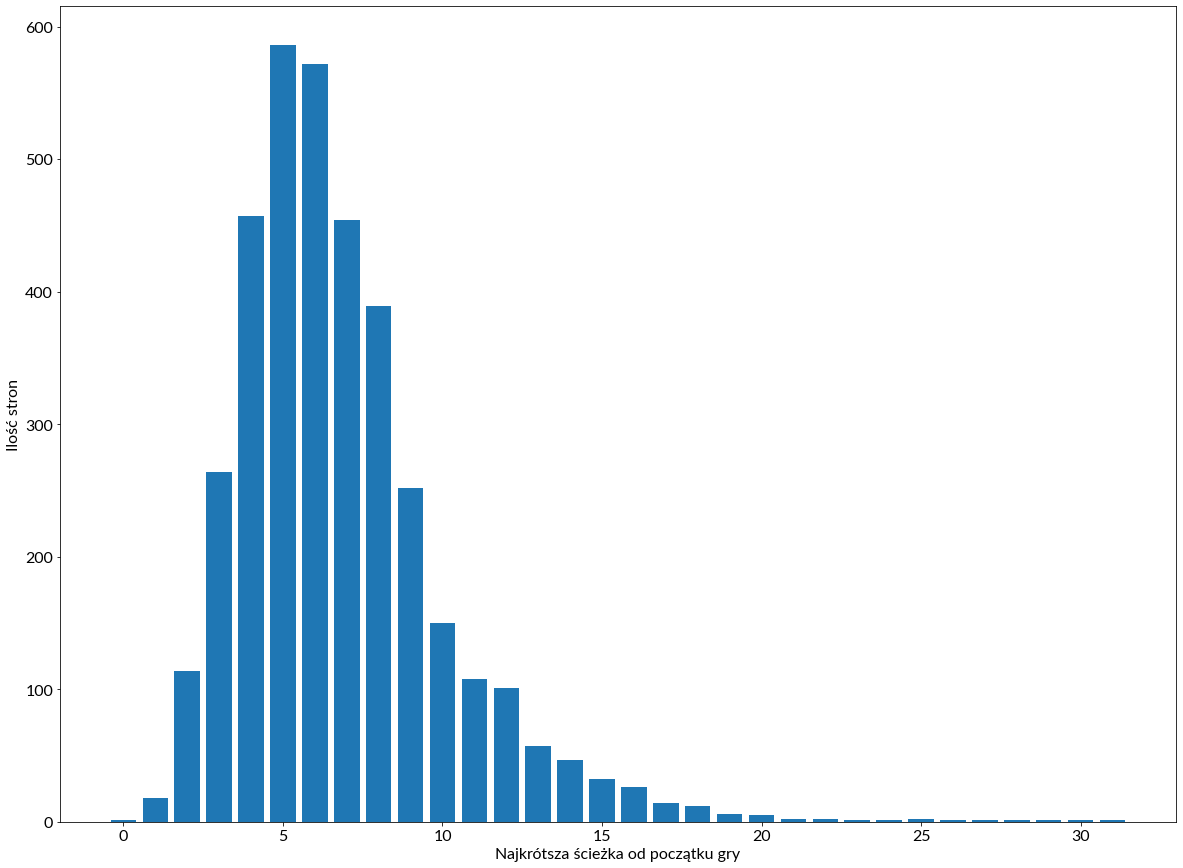

In [38]:
shortest_path_lens = nx.single_source_shortest_path_length(g, 'Gra:Strona 1')
counter = collections.Counter(shortest_path_lens.values())
plt.bar(counter.keys(), counter.values())
plt.xlabel('Najkrótsza ścieżka od początku gry')
plt.ylabel('Ilość stron')
plt.savefig('img/shortest_paths.svg')

print([(v, l) for v, l in shortest_path_lens.items() if l > 19])

PageRank

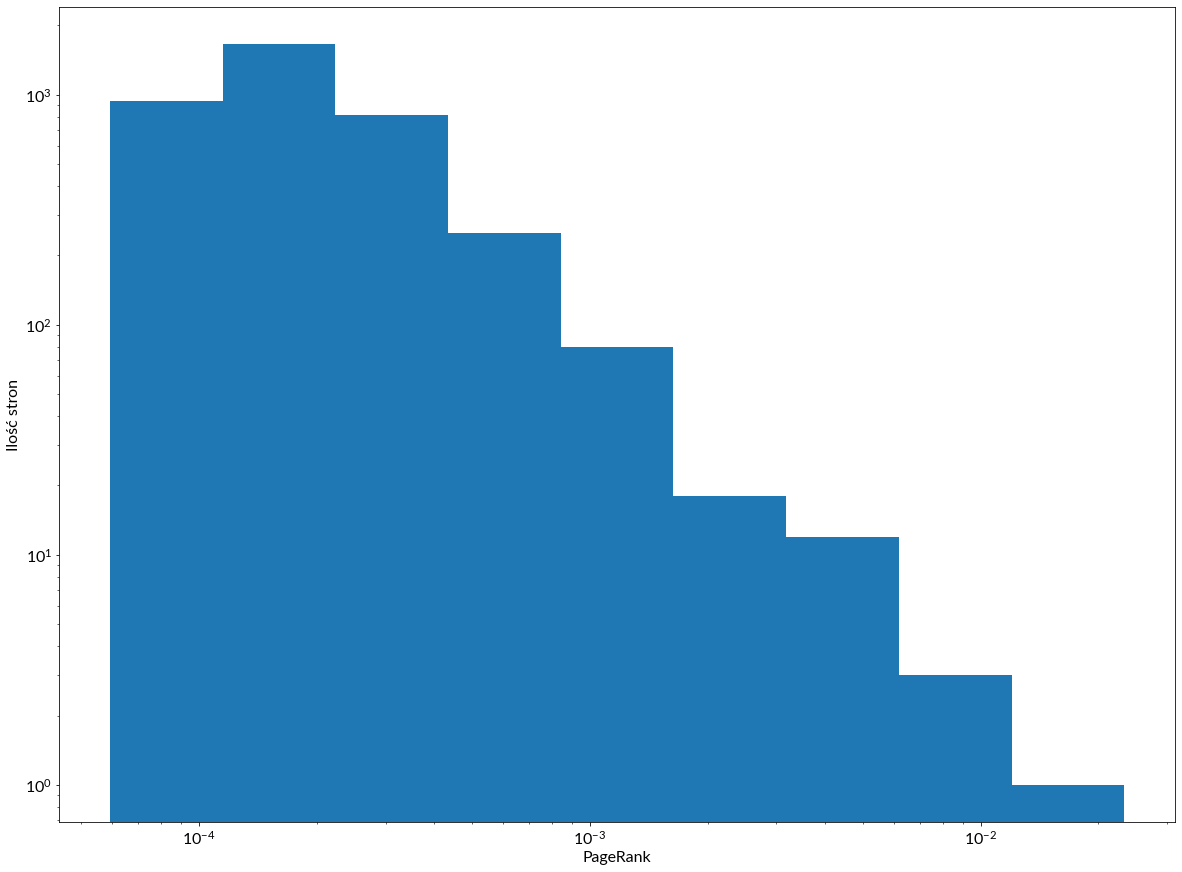

In [39]:
pagerank = nx.pagerank_scipy(g)
pr_numpy = np.array(list(pagerank.values()))
plt.hist(
    pr_numpy,
    bins=np.logspace(np.log10(np.min(pr_numpy)), np.log10(np.max(pr_numpy)), 10),
)
plt.yscale('log')
plt.ylabel('Ilość stron')
plt.xscale('log')
plt.xlabel('PageRank')
plt.savefig('img/pagerank.svg')

Summarize data

In [15]:
df = pd.DataFrame(index=g.nodes)
df['shortest_path'] = pd.Series(shortest_path_lens)
df['pagerank'] = pd.Series(pagerank)


Construct layered thread graph

In [16]:
g2 = g.copy()

threads = set()
for r in res['results']['bindings']:
    if 'threadLabel1' not in r or 'exists1' not in r or r['exists1']['value'] != 'true':
        continue
    node = r['label1']['value']
    if node not in g2:
        continue
    t = r['threadLabel1']['value']
    if t not in threads:
        g2.add_node(t, thread=True)
        threads.add(t)

    g2.add_edge(t, node)
    g2.add_edge(node, t)

Floyd-Warshall, takes a while to compute

In [17]:
floyd = nx.floyd_warshall_numpy(g2)

In [18]:
n_pages = g.number_of_nodes()
thread_distances = floyd[n_pages:, n_pages:]
thread_list = [x for x in g2.nodes if x.startswith('Wątek')]

def map_thread_id(ids):
    return [thread_list[id] for id in ids]

In [19]:
def print_page_list(pages):
    print('[[dane:' + '|]], [[dane:'.join(pages) + '|]]')

In [20]:
print('Unreachable threads:')
print_page_list(map_thread_id((np.count_nonzero(np.isinf(thread_distances), axis=0) > 50).nonzero()[0]))
print()
print('Unescapable threads:')
print_page_list(map_thread_id((np.count_nonzero(np.isinf(thread_distances), axis=1) > 50).nonzero()[0]))

Unreachable threads:
[[dane:Wątek Gry:Ciąg dalszy RPG|]], [[dane:Wątek Gry:Sandwich Revenge|]], [[dane:Wątek Gry:Świątynia|]], [[dane:Wątek Gry:Proxima Ursae III|]], [[dane:Wątek Gry:Nauka dłubania w nosie|]], [[dane:Wątek Gry:Kapelusze Wujka Alfonsa|]]

Unescapable threads:
[[dane:Wątek Gry:Papier kamień nożyce|]], [[dane:Wątek Gry:Standaryzacja bycia uznanym za zmarłego|]], [[dane:Wątek Gry:Biznes narkotykowy|]], [[dane:Wątek Gry:Planeta robotów|]], [[dane:Wątek Gry:Szpital|]], [[dane:Wątek Gry:Sosnowiec|]], [[dane:Wątek Gry:Saper|]], [[dane:Wątek Gry:Spalenie przez Gatesa|]], [[dane:Wątek Gry:Szczurza sekta religijna|]], [[dane:Wątek Gry:Azeroth|]], [[dane:Wątek Gry:Wściekłe Zwierzątko w karczmie|]], [[dane:Wątek Gry:Bezludna wyspa|]], [[dane:Wątek Gry:Szpital psychiatryczny (C)|]], [[dane:Wątek Gry:Oczekiwanie|]], [[dane:Wątek Gry:Czipsy|]], [[dane:Wątek Gry:Czekanie|]], [[dane:Wątek Gry:Bar mleczny|]], [[dane:Wątek Gry:Yoshi|]], [[dane:Wątek Gry:Afryka|]], [[dane:Wątek Gry:Mauzole

In [21]:
def visualize_distance_matrix(m, names):
    masked = np.ma.masked_where(np.isinf(m), m)
    masked2 = np.ma.power(masked, 2)
    # axis=0 is avg reachability
    coords = np.vstack((
        np.array(np.ma.mean(masked2, axis=0)),
        np.array(np.ma.std(masked, axis=0)),
        np.array(np.ma.mean(masked2, axis=1)),
        np.array(np.ma.std(masked, axis=1)),
        np.array(np.ma.count_masked(masked, axis=0)) + np.array(np.ma.count_masked(masked, axis=1)),
    )).transpose()
    c_df = pd.DataFrame(coords, index=names,
                        columns=['reachability', 'reach_std', 'escapeability', 'esc_std', 'empty'])
    c_df = c_df[c_df['empty'] < 0.5 * len(c_df)]

    plt.scatter(c_df['reachability'], c_df['escapeability'], c=c_df['esc_std'],
                norm=colors.Normalize(np.min(np.array(c_df['esc_std']), where=c_df['esc_std'] > 1, initial=100), clip=True),
    )
    plt.xlabel('Trudność dojścia')
    plt.ylabel('Trudność wyjścia')
    cbar = plt.colorbar()
    cbar.set_label('Rozrzut trudności wyjścia')
    return c_df

thread_coords = visualize_distance_matrix(thread_distances, thread_list)
plt.savefig('img/thread_coords.svg', bbox_inches='tight')

In [55]:
def print_page_list_with_data(series, n=10):
    i = 0
    for k, v in series.iteritems():
        if i >= 10:
            break
        i += 1
        print(f'* [[dane:{k}|]] – {v:.2f}')
    pass

print('Hard to reach')
print_page_list_with_data(thread_coords.sort_values('reachability', ascending=False)['reachability'])
print()
print('Hard to escape')
print_page_list_with_data(thread_coords.sort_values('escapeability', ascending=False)['escapeability'])

Hard to reach
* [[dane:Wątek Gry:Masakrowanie PO|]] – 160.61
* [[dane:Wątek Gry:Wampirzyca|]] – 149.75
* [[dane:Wątek Gry:Wehikuł czasu|]] – 139.34
* [[dane:Wątek Gry:Muflony w piekle|]] – 124.93
* [[dane:Wątek Gry:Bitwa pod Grunwaldem|]] – 122.85
* [[dane:Wątek Gry:Złota rybka|]] – 117.25
* [[dane:Wątek Gry:Ptaszysko z głową pijaczka spod sklepu|]] – 117.00
* [[dane:Wątek Gry:Polskie więzienie CIA|]] – 116.35
* [[dane:Wątek Gry:Nawiedzony dom Wiśniewskiego|]] – 105.24
* [[dane:Wątek Gry:Głuptozaurus|]] – 99.05

Hard to escape
* [[dane:Wątek Gry:Piekło dla zmotoryzowanych|]] – 162.94
* [[dane:Wątek Gry:Głuptozaurus|]] – 106.22
* [[dane:Wątek Gry:Muflony w piekle|]] – 96.34
* [[dane:Wątek Gry:Ptaszysko z głową pijaczka spod sklepu|]] – 95.25
* [[dane:Wątek Gry:Admin Wikipedii na ulicy|]] – 93.43
* [[dane:Wątek Gry:Wampirzyca|]] – 92.86
* [[dane:Wątek Gry:Mężczyzna z podziemi|]] – 89.05
* [[dane:Wątek Gry:Spotkanie z dilerem|]] – 83.91
* [[dane:Wątek Gry:Dresiarze|]] – 79.81
* [[dane:Wąt

<Figure size 1440x1080 with 0 Axes>

In [56]:
page_dist = floyd[:n_pages, :n_pages]
page_coords = visualize_distance_matrix(page_dist, g.nodes)
plt.savefig('img/page_coords.svg', bbox_inches='tight')

Transform layered graph into a thread graph

In [24]:
gt = nx.DiGraph()

for i in range(len(threads)):
    gt.add_node(thread_list[i])
    for j in range(len(threads)):
        if np.isclose(thread_distances[i, j], 3.0):
            gt.add_edge(thread_list[i], thread_list[j])

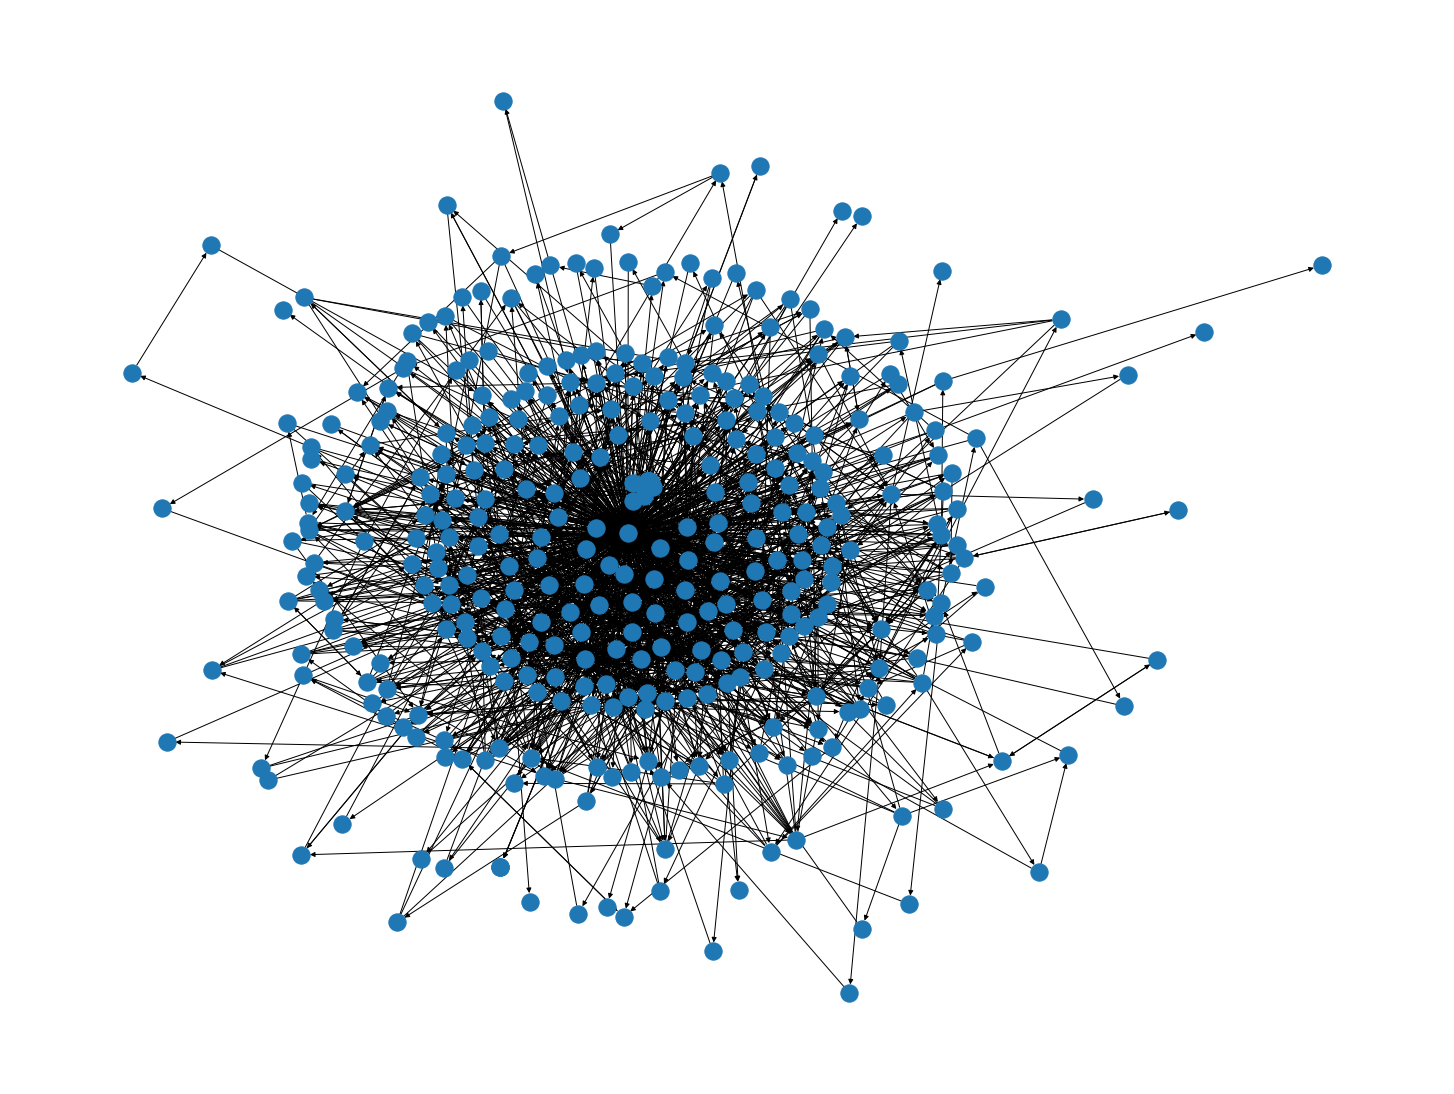

In [57]:
nx.draw_kamada_kawai(gt)
plt.savefig('img/thread_graph.svg', bbox_inches='tight')

This doesn't work yet. The general idea is to split up "brak wątku" into multiple threads or something

In [26]:
g_null = nx.DiGraph()
for r in res['results']['bindings']:
    if 'threadLabel1' not in r or r['threadLabel1']['value'] != 'Wątek Gry:(brak wątku)':
        continue

    g_null.add_node(r['label1']['value'], exists=(r['exists1']['value'] == 'true'))
    for target in r['links']['value'].split('|'):
        if target == '':
            continue
        g_null.add_edge(r['label1']['value'], target)

# restrict the graph to pages that exist
g_null = g_null.subgraph([v for v, exists in g_null.nodes(data='exists') if exists])

In [27]:
nx.write_gexf(g_null, 'export/null_thread.gexf')